In [1]:
import torch
import numpy as np
import pyro
import pyro.distributions as dist
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

%matplotlib inline

pyro.set_rng_seed(1712343505)

/usr/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
fig_format = "pdf"
savefig_opts = {
    "format": fig_format,
    "bbox_inches": "tight",
    "pad_inches": 0.0
}

In [3]:
# Constants
D = 2
n_samples=500
# Model parameters
K = 2
means = torch.tensor([[1.0,1], [3,5]])
covs = torch.tensor([[[1.0,0],[0,1]],[[1,0],[0,1]]])
mix_coeffs = torch.tensor([0.5, 0.5])

# Part 1

In [4]:
def mixture_model(n_samples):
    with pyro.plate("assignment", n_samples):
        z = pyro.sample("z", dist.Categorical(mix_coeffs))
        mean = pyro.deterministic("mean", means[z])
        cov = pyro.deterministic("cov", covs[z])
        x = pyro.sample("x", dist.MultivariateNormal(mean, cov))

    return x

In [5]:
def plot_mixture_model(ax, model):
    points = model(n_samples)
    xs = points[:,0]
    ys = points[:,1]
    
    ax.scatter(xs, ys)
    ax.set_aspect("equal")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(MultipleLocator(1))

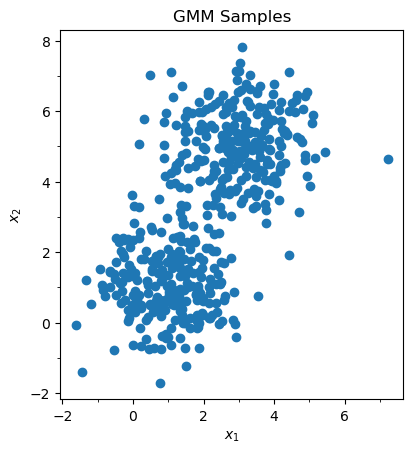

In [6]:
fig, ax = plt.subplots()
ax.set_title("GMM Samples")
plot_mixture_model(ax, mixture_model)
fig.savefig(f"gmm_samples.{fig_format}", **savefig_opts)

# Part 2

In [7]:
def cond_mixture_model(x1, x2):
    d = 0
    x1_ = torch.tensor(x1)
    x1 = torch.full(x2.shape, x1)
    # Compute the divisor
    div = 0
    for k, pi in enumerate(mix_coeffs):
        p_x1_k = torch.exp(dist.Normal(means[k][d], covs[k][d,d]).log_prob(x1_))
        div = div + pi * p_x1_k
    # Sample conditioned GMM
    res = torch.zeros(x2.shape)
    for k, pi in enumerate(mix_coeffs):
        x = torch.dstack((x1, x2))
        p_x_k = torch.exp(dist.MultivariateNormal(means[k], covs[k]).log_prob(x))
        res = res + pi * p_x_k / div
    return res[0]

In [8]:
def plot_cond_mixture(ax, x1):
    x2 = torch.linspace(-2, 8, 50)
    y = cond_mixture_model(x1, x2)
    ax.plot(x2, y)
    ax.set_xlabel("$x_2$")
    ax.set_ylabel("pdf")

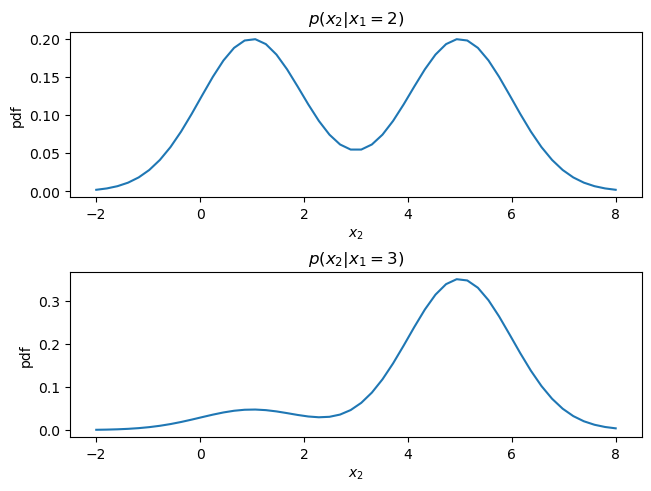

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True)
ax1.set_title("$p(x_2 | x_1 = 2)$")
plot_cond_mixture(ax1, x1=2)
ax2.set_title("$p(x_2 | x_1 = 3)$")
plot_cond_mixture(ax2, x1=3)
fig.savefig(f"cond_pdf.{fig_format}", **savefig_opts)